# Logistic Regression with Scikit-learn
This notebook provides a comprehensive walkthrough of logistic regression using a publicly available dataset from `scikit-learn`

In [8]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

## Load the Dataset
We will use the **Titanic** dataset available from `scikit-learn`.

In [9]:
titanic = sns.load_dataset("titanic")
df = titanic.copy()

In [10]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Understanding titanic dataset columns

In [11]:
# Display column names and their descriptions
column_descriptions = {
    'survived': 'Survival (0 = No, 1 = Yes)',
    'pclass': 'Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)',
    'sex': 'Sex (male, female)',
    'age': 'Age in years',
    'sibsp': 'Number of siblings/spouses aboard',
    'parch': 'Number of parents/children aboard',
    'fare': 'Passenger fare',
    'embarked': 'Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)',
    'class': 'Class name (First, Second, Third)',
    'who': 'Person type (man, woman, child)',
    'adult_male': 'Is adult male (True/False)',
    'deck': 'Deck (A, B, C, D, E, F, G, or NaN)',
    'embark_town': 'Town of embarkation',
    'alive': 'Survived? (yes, no)',
    'alone': 'Traveled alone? (True/False)'
}
for col, desc in column_descriptions.items():
    print(f"{col}: {desc}")

survived: Survival (0 = No, 1 = Yes)
pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
sex: Sex (male, female)
age: Age in years
sibsp: Number of siblings/spouses aboard
parch: Number of parents/children aboard
fare: Passenger fare
embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
class: Class name (First, Second, Third)
who: Person type (man, woman, child)
adult_male: Is adult male (True/False)
deck: Deck (A, B, C, D, E, F, G, or NaN)
embark_town: Town of embarkation
alive: Survived? (yes, no)
alone: Traveled alone? (True/False)


## Building a base line model

## pre processing the dataset

In [12]:
# Select a subset of columns for the baseline model
# We use only basic features and drop rows with missing values for simplicity
df_base = df[['survived', 'pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']].dropna()

In [13]:
# Encode 'sex' as numeric: male=0, female=1
df_base['sex'] = df_base['sex'].map({'male': 0, 'female': 1})

In [14]:
# Encode 'embarked' as dummy variables (one-hot encoding), dropping the first to avoid multicollinearity
df_base = pd.get_dummies(df_base, columns=['embarked'], drop_first=True)

In [15]:
df_base.head()

,survived,pclass,sex,age,fare,sibsp,parch,embarked_Q,embarked_S
0,0,3,0,22.0,7.2500,1,0,False,True
1,1,1,1,38.0,71.2833,1,0,False,False
2,1,3,1,26.0,7.9250,0,0,False,True
3,1,1,1,35.0,53.1000,1,0,False,True
4,0,3,0,35.0,8.0500,0,0,False,True


In [16]:
# Features and target
X_base = df_base.drop('survived', axis=1)
y_base = df_base['survived']

In [18]:
# Split into train and test sets (stratify to keep class balance)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

In [19]:
# Initialize and train logistic regression
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_base, y_train_base)

LogisticRegression(max_iter=1000)

In [24]:
# Create a sample record (use the same features as X_train_base)
# For Titanic dataset, this could be:
sample_passenger = pd.DataFrame({
    'pclass': [3],                # 3rd class passenger
    'sex': [0],                   # male (0) or female (1)
    'age': [25],                  # 25 years old
    'fare': [7.25],               # ticket fare
    'sibsp': [1],                 # 1 sibling/spouse aboard
    'parch': [0],                 # 0 parents/children aboard
    'embarked_Q': [0],            # not embarked from Queenstown
    'embarked_S': [1]             # embarked from Southampton
})

# Make a prediction (0 or 1)
prediction = baseline_model.predict(sample_passenger)
print(f"Prediction (0=Not Survived, 1=Survived): {prediction[0]}")

# Get the probability of each class
probabilities = baseline_model.predict_proba(sample_passenger)
print(f"Probability of Not Surviving (Class 0): {probabilities[0][0]:.4f}")
print(f"Probability of Surviving (Class 1): {probabilities[0][1]:.4f}")

Prediction (0=Not Survived, 1=Survived): 0
Probability of Not Surviving (Class 0): 0.9102
Probability of Surviving (Class 1): 0.0898


In [20]:
# Make predictions and get probabilities for ROC curve
y_pred_base = baseline_model.predict(X_test_base)
y_prob_base = baseline_model.predict_proba(X_test_base)[:, 1]

In [21]:
# Print accuracy and ROC AUC
print("Baseline Accuracy:", accuracy_score(y_test_base, y_pred_base))
print("Baseline ROC AUC:", roc_auc_score(y_test_base, y_prob_base))
print(classification_report(y_test_base, y_pred_base))

Baseline Accuracy: 0.7972027972027972
Baseline ROC AUC: 0.8585192697768762
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        85
           1       0.76      0.72      0.74        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



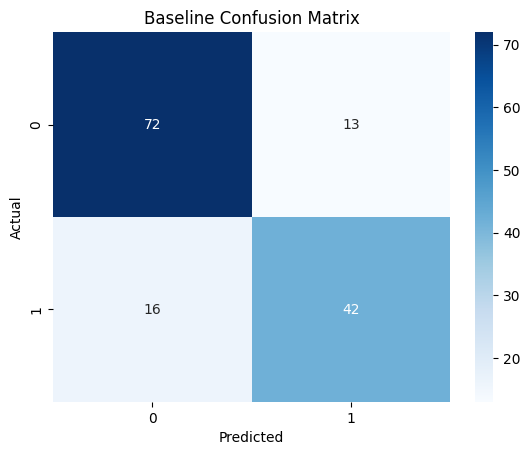

In [22]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test_base, y_pred_base), annot=True, fmt='d', cmap='Blues')
plt.title('Baseline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

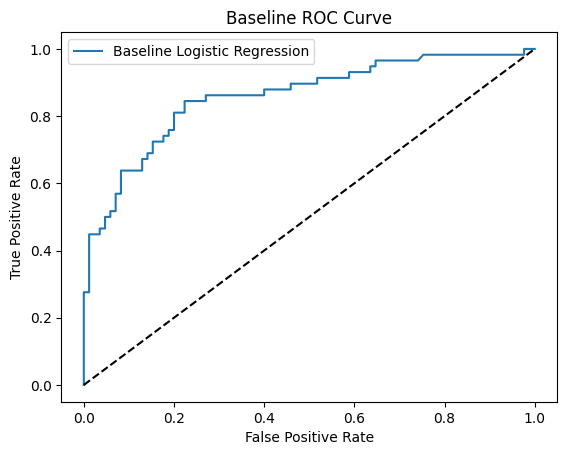

In [25]:
# Plot ROC curve for baseline model
#The area under the ROC curve (AUC) summarizes this performance into a single number: 
#the closer the AUC is to 1, the better the model is at separating the classes, 
#while an AUC of 0.5 means the model performs no better than random guessing.
fpr_base, tpr_base, _ = roc_curve(y_test_base, y_prob_base)
plt.plot(fpr_base, tpr_base, label='Baseline Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline ROC Curve')
plt.legend()
plt.show()

## Building a more advanced model

## enhanced feature engineering and selection

In [26]:
# Make a copy for improved model
df_imp = df.copy()

# Fill missing values for 'age' and 'fare' with median, 'embarked' with mode
df_imp['age'] = df_imp['age'].fillna(df_imp['age'].median())
df_imp['fare'] = df_imp['fare'].fillna(df_imp['fare'].median())
df_imp['embarked'] = df_imp['embarked'].fillna(df_imp['embarked'].mode()[0])

# Feature engineering:
# - family_size: total number of family members aboard (sibsp + parch + 1 for self)
# - is_alone: 1 if traveling alone, 0 otherwise
df_imp['family_size'] = df_imp['sibsp'] + df_imp['parch'] + 1
df_imp['is_alone'] = (df_imp['family_size'] == 1).astype(int)

# Encode 'sex' as numeric: male=0, female=1
df_imp['sex'] = df_imp['sex'].map({'male': 0, 'female': 1})

# One-hot encode 'embarked', drop first column to avoid dummy variable trap
df_imp = pd.get_dummies(df_imp, columns=['embarked'], drop_first=True)

# Select features for improved model
# - pclass: Ticket class (1, 2, 3)
# - sex: Gender (0=male, 1=female)
# - age: Age in years
# - fare: Ticket fare
# - sibsp: Siblings/spouses aboard
# - parch: Parents/children aboard
# - family_size: Total family members aboard
# - is_alone: 1 if alone, 0 otherwise
# - embarked_Q, embarked_S: Embarkation ports (Q=Queenstown, S=Southampton, C is baseline)
features = [
    'pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'family_size', 'is_alone',
    'embarked_Q', 'embarked_S'
]
X_imp = df_imp[features]
y_imp = df_imp['survived']

## polynomial features
	`PolynomialFeatures` is a tool from scikit-learn that creates new features by combining your existing features in polynomial ways.
	•	Polynomial features are new features created by multiplying your original features together (and possibly raising them to powers).
	•	For example, if you have features `A` and `B`, degree=2 would create: `A`, `B`, `A^2`, `B^2`, and `A*B`.
	•	`degree=2` means we are creating all possible products of two features (including the feature squared, unless `interaction_only=True`).
	•	`interaction_only=True` means only interaction terms are created (e.g., `A*B`), not squared terms like `A^2` or `B^2`.
	•	`include_bias=False` means we do not add a column of all 1s (which would act as an intercept term).

In [27]:
# Add polynomial and interaction features (degree=2, interaction only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_imp)
poly_feature_names = poly.get_feature_names_out(features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

In [28]:
X_poly_df.head()

,pclass,sex,age,fare,sibsp,parch,family_size,is_alone,embarked_Q,embarked_S,...,parch family_size,parch is_alone,parch embarked_Q,parch embarked_S,family_size is_alone,family_size embarked_Q,family_size embarked_S,is_alone embarked_Q,is_alone embarked_S,embarked_Q embarked_S
0,3.0,0.0,22.0,7.2500,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,26.0,7.9250,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,35.0,8.0500,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [29]:
X_poly_df.columns

Index(['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'family_size',
       'is_alone', 'embarked_Q', 'embarked_S', 'pclass sex', 'pclass age',
       'pclass fare', 'pclass sibsp', 'pclass parch', 'pclass family_size',
       'pclass is_alone', 'pclass embarked_Q', 'pclass embarked_S', 'sex age',
       'sex fare', 'sex sibsp', 'sex parch', 'sex family_size', 'sex is_alone',
       'sex embarked_Q', 'sex embarked_S', 'age fare', 'age sibsp',
       'age parch', 'age family_size', 'age is_alone', 'age embarked_Q',
       'age embarked_S', 'fare sibsp', 'fare parch', 'fare family_size',
       'fare is_alone', 'fare embarked_Q', 'fare embarked_S', 'sibsp parch',
       'sibsp family_size', 'sibsp is_alone', 'sibsp embarked_Q',
       'sibsp embarked_S', 'parch family_size', 'parch is_alone',
       'parch embarked_Q', 'parch embarked_S', 'family_size is_alone',
       'family_size embarked_Q', 'family_size embarked_S',
       'is_alone embarked_Q', 'is_alone embarked_S', 'embarked_Q 

## Feature scaling

In [30]:
# Standardize features to mean=0, std=1 for better model convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly_df)

In [32]:
X_scaled

array([[ 0.82737724, -0.73769513, -0.56573646, ..., -0.26142939,
        -0.89239619,  0.        ],
       [-1.56610693,  1.35557354,  0.66386103, ..., -0.26142939,
        -0.89239619,  0.        ],
       [ 0.82737724,  1.35557354, -0.25833709, ..., -0.26142939,
         1.12057851,  0.        ],
       ...,
       [ 0.82737724,  1.35557354, -0.1046374 , ..., -0.26142939,
        -0.89239619,  0.        ],
       [-1.56610693, -0.73769513, -0.25833709, ..., -0.26142939,
        -0.89239619,  0.        ],
       [ 0.82737724, -0.73769513,  0.20276197, ...,  3.8251247 ,
        -0.89239619,  0.        ]])

In [35]:
X_scaled.shape

(891, 55)

## Hyperparameter tuning

StratifiedKFold is a cross-validation technique that splits your dataset into `n_splits` (here, 5) foldsStratified means each fold will have roughly the same proportion of each class (e.g., survived/not survived) as the whole dataset. This is crucial for imbalanced datasets.shuffle=True randomly shuffles the data before splitting, which helps ensure each fold is representative.random_state=42 sets the random seed, so you get the same splits each time you run the code (for reproducibility).

`'C'`:
	•	This is the inverse of regularization strength (lambda).
	•	Smaller values (e.g., 0.01) mean stronger regularization (the model is more constrained, less likely to overfit).
	•	Larger values (e.g., 100) mean weaker regularization (the model can fit the data more closely, possibly overfitting).

'solver':
	•	This tells the algorithm which optimization method to use to find the best model parameters.
	•	'liblinear': Good for small datasets, supports L1 and L2 regularization.
	•	'lbfgs': Good for larger datasets, only supports L2 regularization, generally faster for multiclass problems.

`'class_weight'`:
	•	This controls how the model handles class imbalance (e.g., more non-survivors than survivors).
	•	`None`: No weighting; treats all classes equally.
	•	`'balanced'`: Automatically adjusts weights inversely proportional to class frequencies (helps if you have imbalanced classes).


In [34]:
# Use stratified K-fold cross-validation to keep class balance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up grid search for logistic regression hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced']  # Try both balanced and unbalanced
}
logreg = LogisticRegression(max_iter=1000)
grid = GridSearchCV(logreg, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)
grid.fit(X_scaled, y_imp)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}


Final evaluation on test set

In [38]:
# Split the improved data for final test
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_scaled, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)

# Train with best parameters from grid search
improved_model = grid.best_estimator_
improved_model.fit(X_train_imp, y_train_imp)
y_pred_imp = improved_model.predict(X_test_imp)
y_prob_imp = improved_model.predict_proba(X_test_imp)[:, 1]

print("Improved Accuracy:", accuracy_score(y_test_imp, y_pred_imp))
print("Improved ROC AUC:", roc_auc_score(y_test_imp, y_prob_imp))
print(classification_report(y_test_imp, y_pred_imp))

Improved Accuracy: 0.8044692737430168
Improved ROC AUC: 0.8509881422924901
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       110
           1       0.83      0.62      0.71        69

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



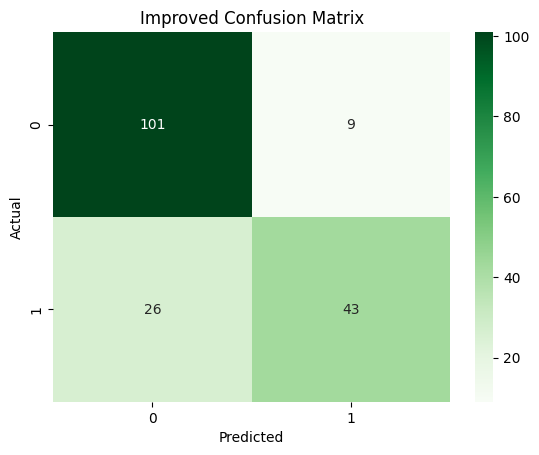

In [39]:
sns.heatmap(confusion_matrix(y_test_imp, y_pred_imp), annot=True, fmt='d', cmap='Greens')
plt.title('Improved Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

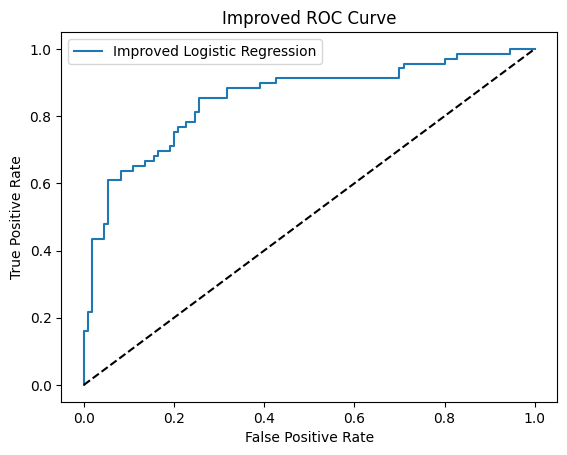

In [40]:
# Plot ROC curve for improved model
fpr_imp, tpr_imp, _ = roc_curve(y_test_imp, y_prob_imp)
plt.plot(fpr_imp, tpr_imp, label='Improved Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Improved ROC Curve')
plt.legend()
plt.show()

In [42]:
y_test_imp

565    0
160    0
553    1
860    0
241    1
      ..
880    1
91     0
883    0
473    1
637    0
Name: survived, Length: 179, dtype: int64

In [44]:
y_test_base

190    1
292    0
762    1
737    1
812    0
      ..
672    0
316    1
135    0
419    0
827    1
Name: survived, Length: 143, dtype: int64

In [47]:
#the number of rows in the original data frame are lower due to the way the rows with missing data has been handled

performance comparison

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Baseline model metrics
baseline_accuracy = accuracy_score(y_test_base, y_pred_base)
baseline_precision = precision_score(y_test_base, y_pred_base)
baseline_recall = recall_score(y_test_base, y_pred_base)
baseline_f1 = f1_score(y_test_base, y_pred_base)
baseline_roc_auc = roc_auc_score(y_test_base, y_prob_base)

# Improved model metrics
improved_accuracy = accuracy_score(y_test_imp, y_pred_imp)
improved_precision = precision_score(y_test_imp, y_pred_imp)
improved_recall = recall_score(y_test_imp, y_pred_imp)
improved_f1 = f1_score(y_test_imp, y_pred_imp)
improved_roc_auc = roc_auc_score(y_test_imp, y_prob_imp)

# Create summary table as a DataFrame
summary_df = pd.DataFrame({
    'Model': ['Baseline', 'Improved'],
    'Accuracy': [baseline_accuracy, improved_accuracy],
    'Precision': [baseline_precision, improved_precision],
    'Recall': [baseline_recall, improved_recall],
    'F1 Score': [baseline_f1, improved_f1],
    'ROC AUC': [baseline_roc_auc, improved_roc_auc],
})

# Display the summary table
summary_df.set_index('Model', inplace=True)
display(summary_df.round(3))

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Baseline,0.797,0.764,0.724,0.743,0.859
Improved,0.804,0.827,0.623,0.711,0.851


The improved model is more conservative: it predicts “survived” less often, but when it does, it’s more likely to be correct.

If our goal is to avoid false positives (e.g., only want to predict “survived” if you’re very sure), the improved model is better.

If our goal is to catch as many survivors as possible (high recall), the baseline model is better.

## Summary of metrics
Accuracy: Proportion of total correct predictions.

Precision: Of all predicted positives, how many were actually positive? (Good for minimizing false positives.)

Recall: Of all actual positives, how many did the model correctly identify? (Good for minimizing false negatives.)

F1 Score: Harmonic mean of precision and recall (balances both).

ROC AUC: Measures the model’s ability to distinguish between classes (higher is better).